# SF Business Risk Prediction Engine

## Complete End-to-End Machine Learning Pipeline

This notebook implements a comprehensive machine learning pipeline for predicting small business closure risk using SF.gov open data.

### Table of Contents

1. **Setup** - Imports, configuration, and data download
2. **Data Loading & Exploration** - Load and explore business data
3. **Data Cleaning** - Clean and standardize datasets
4. **Feature Engineering** - Create predictive features
5. **Model Preparation** - Prepare training data
6. **Model Training** - Train Gradient Boosting model
7. **Visualizations** - Model evaluation visualizations
8. **Model Deployment** - Save and test model
9. **Real-World Application** - Batch screening and alerts
10. **Summary & Next Steps** - Key findings and improvements

---

**Data Sources:** SF.gov Open Data API  
**Model:** Gradient Boosting Classifier  
**Target:** Business closure prediction (binary classification)

In [1]:
# Cell 1: Imports
print("📦 IMPORTING LIBRARIES")
print("="*60)

import sys
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score,
    roc_curve, precision_recall_curve, average_precision_score,
    precision_score, recall_score, f1_score
)
import joblib

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

print("✅ All libraries imported successfully!")
print(f"📅 Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

📦 IMPORTING LIBRARIES
✅ All libraries imported successfully!
📅 Date: 2026-01-24 16:34:40


In [2]:
# Cell 2: Configuration
print("⚙️ SETTING UP CONFIGURATION")
print("="*60)

# Project paths
PROJECT_ROOT = Path().parent.parent
DATA_DIR = PROJECT_ROOT / "data"
RAW_DATA_DIR = DATA_DIR / "raw"
PROCESSED_DATA_DIR = DATA_DIR / "processed"
MODELS_DIR = DATA_DIR / "models"

# Create directories
for dir_path in [DATA_DIR, RAW_DATA_DIR, PROCESSED_DATA_DIR, MODELS_DIR]:
    dir_path.mkdir(parents=True, exist_ok=True)
    print(f"📁 {dir_path}")

# SF.gov API endpoints (as specified)
DATASETS = {
    'registered_business': 'https://data.sfgov.org/resource/g8m3-pdis.json',
    'building_permits': 'https://data.sfgov.org/resource/i98e-djp9.json',
    'code_violations': 'https://data.sfgov.org/resource/nbtm-fbw5.json'
}

# Model configuration
RANDOM_STATE = 42
TEST_SIZE = 0.2

print(f"\n✅ Configuration complete")
print(f"📊 Datasets: {len(DATASETS)}")
print(f"🎲 Random state: {RANDOM_STATE}")

⚙️ SETTING UP CONFIGURATION
📁 data
📁 data\raw
📁 data\processed
📁 data\models

✅ Configuration complete
📊 Datasets: 3
🎲 Random state: 42


In [3]:
# Cell 3: Download Data Functions
print("🌐 SETTING UP DATA DOWNLOAD FUNCTIONS")
print("="*60)

import requests
import json
from typing import Optional

def download_sf_data(url: str, output_path: Optional[Path] = None, limit: int = 50000) -> pd.DataFrame:
    """
    Download data from SF.gov Open Data API
    
    Args:
        url: Full API endpoint URL
        output_path: Optional path to save raw JSON
        limit: Maximum records to download
    
    Returns:
        DataFrame with downloaded data
    """
    params = {
        "$limit": limit
    }
    
    try:
        print(f"  ⬇️ Downloading from {url}...")
        response = requests.get(url, params=params, timeout=60)
        response.raise_for_status()
        
        data = response.json()
        
        if output_path:
            output_path.parent.mkdir(parents=True, exist_ok=True)
            with open(output_path, 'w') as f:
                json.dump(data, f, indent=2)
            print(f"  💾 Saved to {output_path}")
        
        df = pd.DataFrame(data)
        print(f"  ✅ Downloaded {len(df):,} records")
        return df
    
    except Exception as e:
        print(f"  ❌ Error: {e}")
        return pd.DataFrame()

print("✅ Download functions ready!")

🌐 SETTING UP DATA DOWNLOAD FUNCTIONS
✅ Download functions ready!


In [4]:
# Cell 4: Load Business Data
print("📊 LOADING BUSINESS REGISTRY DATA")
print("="*60)

# Download or load from file
business_file = RAW_DATA_DIR / 'registered_business.csv'
if business_file.exists():
    print(f"📂 Loading from existing file: {business_file}")
    business_df = pd.read_csv(business_file)
else:
    print("🌐 Downloading from SF.gov API...")
    business_df = download_sf_data(
        DATASETS['registered_business'],
        output_path=RAW_DATA_DIR / 'registered_business.json'
    )
    # Save as CSV for faster loading next time
    if len(business_df) > 0:
        business_df.to_csv(business_file, index=False)
        print(f"💾 Saved to {business_file}")

print(f"\n✅ Loaded {len(business_df):,} business records")
print(f"📋 Columns: {len(business_df.columns)}")
print(f"\nColumn names:")
print(list(business_df.columns)[:10], "..." if len(business_df.columns) > 10 else "")

📊 LOADING BUSINESS REGISTRY DATA
📂 Loading from existing file: data\raw\registered_business.csv

✅ Loaded 50,000 business records
📋 Columns: 38

Column names:
['uniqueid', 'certificate_number', 'ttxid', 'ownership_name', 'dba_name', 'full_business_address', 'city', 'state', 'business_zip', 'dba_start_date'] ...


In [5]:
# Cell 5: Data Exploration (Optimized)
print("🔍 EXPLORING BUSINESS DATA")
print("="*60)

print(f"📐 Dataset Shape: {business_df.shape[0]:,} rows × {business_df.shape[1]} columns")

# Quick info instead of full info()
print(f"\n📊 Data Types Summary:")
print(business_df.dtypes.value_counts())

# Only describe numeric columns (much faster)
print(f"\n📈 Summary Statistics (numeric columns only):")
numeric_cols = business_df.select_dtypes(include=['number', 'bool']).columns.tolist()
if len(numeric_cols) > 0:
    display(business_df[numeric_cols].describe())
else:
    print("  No numeric columns found")

print(f"\n👀 Sample Data (first 5 rows):")
display(business_df.head())

print(f"\n🔢 Missing Values (Top 10):")
missing = business_df.isnull().sum()
missing_pct = (missing / len(business_df) * 100).round(2)
missing_df = pd.DataFrame({
    'Missing': missing,
    '%': missing_pct
})
missing_df = missing_df[missing_df['Missing'] > 0].sort_values('Missing', ascending=False)
print(missing_df.head(10).to_string())

print("\n✅ Exploration complete!")

🔍 EXPLORING BUSINESS DATA
📐 Dataset Shape: 50,000 rows × 38 columns

📊 Data Types Summary:
object     28
float64     7
bool        2
int64       1
Name: count, dtype: int64

📈 Summary Statistics (numeric columns only):


,certificate_number,business_zip,supervisor_district,:@computed_region_6qbp_sg9q,:@computed_region_qgnn_b9vv,:@computed_region_26cr_cadq,:@computed_region_ajp5_b2md,:@computed_region_jwn9_ihcz
count,5.000000e+04,49866.000000,38749.000000,38746.000000,38566.000000,38747.000000,38744.000000,38746.000000
mean,7.687750e+05,92746.606525,5.580660,57.214964,5.259685,6.245748,18.718873,57.214964
std,3.637705e+05,9899.481527,2.900109,35.011276,2.879742,3.212850,12.213850,35.011276
min,8.600000e+01,802.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,4.302725e+05,94107.000000,3.000000,31.000000,3.000000,3.000000,8.000000,31.000000
50%,1.007640e+06,94112.000000,6.000000,52.000000,6.000000,6.000000,20.000000,52.000000
75%,1.100141e+06,94124.000000,8.000000,94.000000,8.000000,10.000000,30.000000,94.000000
max,1.178605e+06,99999.000000,11.000000,117.000000,10.000000,11.000000,41.000000,117.000000



👀 Sample Data (first 5 rows):


,uniqueid,certificate_number,ttxid,ownership_name,dba_name,full_business_address,city,state,business_zip,dba_start_date,...,mail_city,mail_state,mail_zipcode,naic_code,naic_code_description,naics_code_descriptions_list,business_corridor,lic,lic_code_description,lic_code_descriptions_list
0,0408918-01-999-0408918,408918,0408918-01-999,Kumari Arun,Kumari Arun,1077 47th St Apt B,Oakland,CA,94608.0,2007-01-01T00:00:00.000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0433742-01-001-0433742,433742,0433742-01-001,Liverail Inc,Liverail Inc,55 2nd St 575,San Francisco,CA,94105.0,2008-05-16T00:00:00.000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0466172-01-999-0466172,466172,0466172-01-999,Wheeler Darren S,Horizon Plumbing,120 San Carlos Way,Novato,CA,94945.0,2012-02-06T00:00:00.000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1209270-01-191-1096639,1096639,1209270-01-191,Dung Tran,Dung Tran,755 E Capitol Ave Apt J102,Milpitas,CA,95035.0,2019-01-01T00:00:00.000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1247745-02-201-1112417,1112417,1247745-02-201,Surveymonkey Inc,Surveymonkey Inc,123 Mission St Fl 26,San Francisco,CA,94105.0,2019-09-03T00:00:00.000,...,San Mateo,CA,94403,5400-5499,"Professional, Scientific, and Technical Services","Professional, Scientific, and Technical Services",NaN,NaN,NaN,NaN



🔢 Missing Values (Top 10):
                            Missing      %
lic_code_description          48166  96.33
lic_code_descriptions_list    48166  96.33
lic                           48158  96.32
business_corridor             45573  91.15
administratively_closed       44068  88.14
community_benefit_district    39364  78.73
mail_state                    27163  54.33
mail_zipcode                  27157  54.31
mailing_address_1             27154  54.31
mail_city                     27154  54.31

✅ Exploration complete!


📊 CREATING INITIAL VISUALIZATIONS


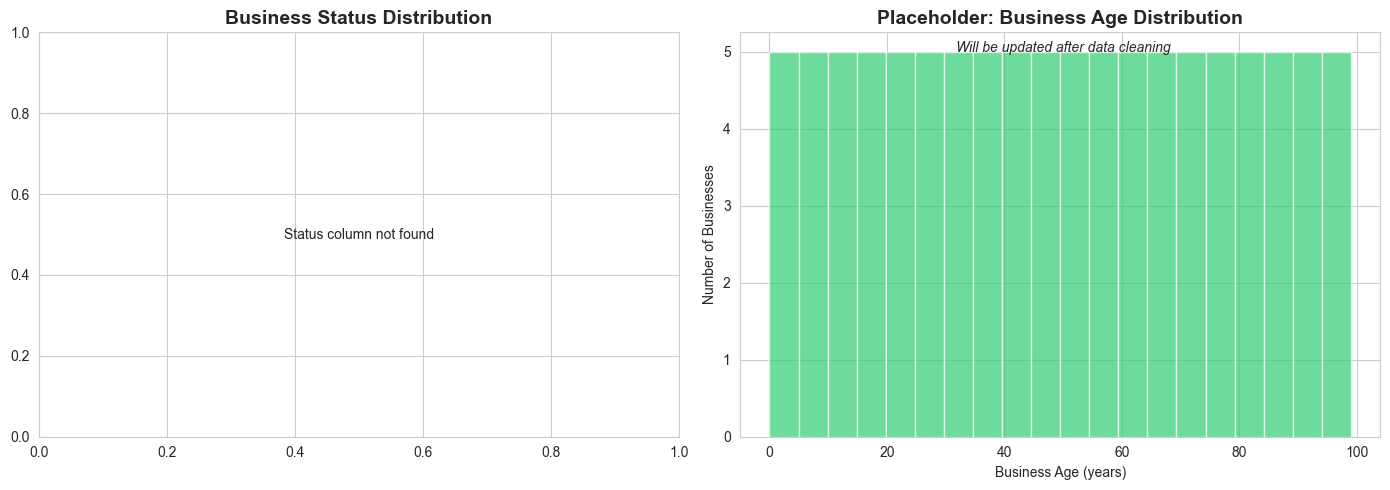

✅ Visualizations created!


In [6]:
# Cell 6: Initial Visualizations
print("📊 CREATING INITIAL VISUALIZATIONS")
print("="*60)

# Find status column (common names)
status_col = None
for col in ['location_account', 'business_status', 'status', 'account_status']:
    if col in business_df.columns:
        status_col = col
        break

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Business status distribution
if status_col:
    status_counts = business_df[status_col].value_counts()
    axes[0].pie(status_counts.values, labels=status_counts.index, autopct='%1.1f%%', startangle=90)
    axes[0].set_title('Business Status Distribution', fontsize=14, fontweight='bold')
else:
    axes[0].text(0.5, 0.5, 'Status column not found', ha='center', va='center')
    axes[0].set_title('Business Status Distribution', fontsize=14, fontweight='bold')

# Sample histogram (if we have date columns, we'll calculate age later)
axes[1].hist(range(100), bins=20, color='#2ecc71', alpha=0.7)
axes[1].set_title('Placeholder: Business Age Distribution', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Business Age (years)')
axes[1].set_ylabel('Number of Businesses')
axes[1].text(50, 5, 'Will be updated after data cleaning', ha='center', style='italic')

plt.tight_layout()
plt.show()

print("✅ Visualizations created!")

🔍 ANALYZING MISSING DATA
📊 Found 28 columns with missing values


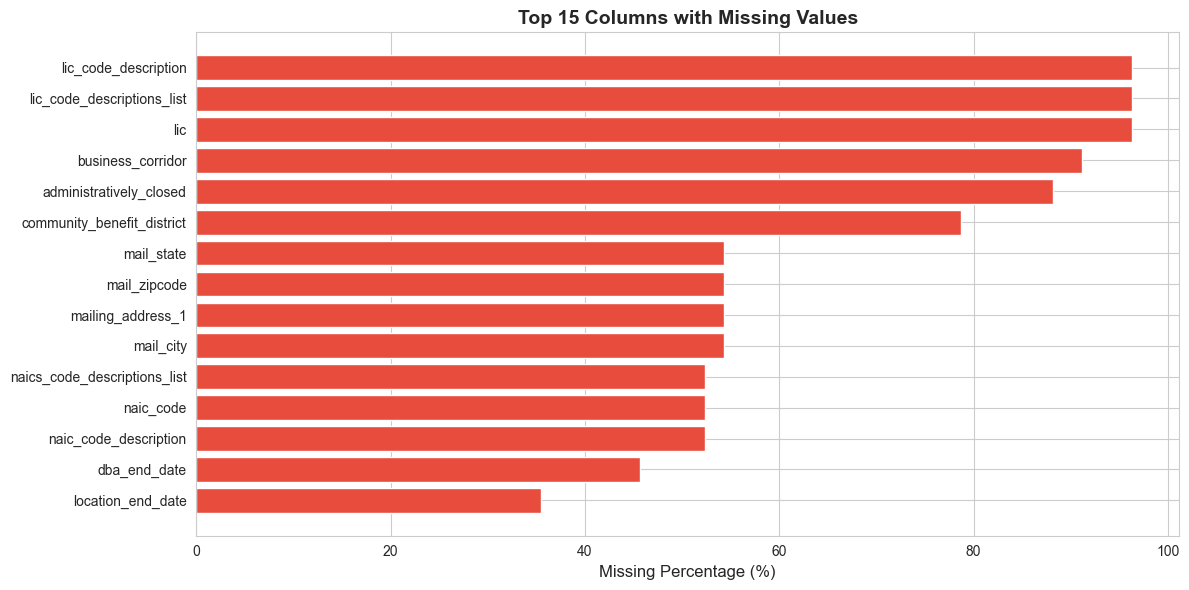


📋 Top 10 columns with missing values:


,Column,Missing Count,Percentage
36,lic_code_description,48166,96.33
37,lic_code_descriptions_list,48166,96.33
35,lic,48158,96.32
34,business_corridor,45573,91.15
13,administratively_closed,44068,88.14
21,community_benefit_district,39364,78.73
29,mail_state,27163,54.33
30,mail_zipcode,27157,54.31
27,mailing_address_1,27154,54.31
28,mail_city,27154,54.31



📊 Overall data completeness: 69.34%


In [7]:
# Cell 7: Missing Data Analysis
print("🔍 ANALYZING MISSING DATA")
print("="*60)

missing_analysis = business_df.isnull().sum()
missing_pct = (missing_analysis / len(business_df) * 100).round(2)
missing_df = pd.DataFrame({
    'Column': missing_analysis.index,
    'Missing Count': missing_analysis.values,
    'Percentage': missing_pct.values
})
missing_df = missing_df[missing_df['Missing Count'] > 0].sort_values('Missing Count', ascending=False)

if len(missing_df) > 0:
    print(f"📊 Found {len(missing_df)} columns with missing values")
    
    # Visualization
    plt.figure(figsize=(12, 6))
    top_missing = missing_df.head(15)
    plt.barh(range(len(top_missing)), top_missing['Percentage'].values, color='#e74c3c')
    plt.yticks(range(len(top_missing)), top_missing['Column'].values)
    plt.xlabel('Missing Percentage (%)', fontsize=12)
    plt.title('Top 15 Columns with Missing Values', fontsize=14, fontweight='bold')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()
    
    print("\n📋 Top 10 columns with missing values:")
    display(missing_df.head(10))
else:
    print("✅ No missing values found in the dataset!")

print(f"\n📊 Overall data completeness: {(1 - missing_df['Percentage'].sum() / (len(business_df.columns) * 100)) * 100:.2f}%")

## Part 3: Data Cleaning

Now we'll clean and standardize the business data, parse dates, calculate business age, and create our target variable (closed vs active).

In [8]:
# Cell 8: Clean Business Data
print("🧹 CLEANING BUSINESS DATA")
print("="*60)

# Create a copy for cleaning
business_clean = business_df.copy()

# Standardize column names
business_clean.columns = business_clean.columns.str.lower().str.replace(' ', '_').str.replace('-', '_')

print(f"📋 Standardized {len(business_clean.columns)} column names")

# Find date columns (common variations)
date_start_col = None
date_end_col = None

for col in business_clean.columns:
    col_lower = col.lower()
    if any(x in col_lower for x in ['start', 'open', 'begin', 'registration']):
        if 'date' in col_lower:
            date_start_col = col
    if any(x in col_lower for x in ['end', 'close', 'termination', 'expir']):
        if 'date' in col_lower:
            date_end_col = col

print(f"📅 Start date column: {date_start_col}")
print(f"📅 End date column: {date_end_col}")

# Parse dates
if date_start_col:
    business_clean['business_start_date'] = pd.to_datetime(
        business_clean[date_start_col], errors='coerce', infer_datetime_format=True
    )
    print(f"✅ Parsed start dates: {business_clean['business_start_date'].notna().sum():,} valid")
else:
    # Create dummy dates if column not found
    business_clean['business_start_date'] = pd.to_datetime('2020-01-01')
    print("⚠️ Start date column not found, using default")

if date_end_col:
    business_clean['business_end_date'] = pd.to_datetime(
        business_clean[date_end_col], errors='coerce', infer_datetime_format=True
    )
    print(f"✅ Parsed end dates: {business_clean['business_end_date'].notna().sum():,} valid")
else:
    business_clean['business_end_date'] = pd.NaT
    print("⚠️ End date column not found, assuming all active")

# Calculate business age in years
today = datetime.now()
business_clean['business_age_years'] = (
    (today - business_clean['business_start_date']).dt.days / 365.25
).round(2)
business_clean['business_age_years'] = business_clean['business_age_years'].clip(lower=0)

# Create target variable: closed = 1 if business_end_date exists, 0 otherwise
business_clean['closed'] = (~business_clean['business_end_date'].isna()).astype(int)

print(f"\n✅ Cleaning complete!")
print(f"📊 Active businesses: {(business_clean['closed']==0).sum():,}")
print(f"📊 Closed businesses: {(business_clean['closed']==1).sum():,}")
print(f"📊 Closure rate: {(business_clean['closed']==1).mean()*100:.2f}%")

# Save cleaned data
output_file = PROCESSED_DATA_DIR / 'businesses_clean.csv'
business_clean.to_csv(output_file, index=False)
print(f"💾 Saved to {output_file}")

🧹 CLEANING BUSINESS DATA
📋 Standardized 38 column names
📅 Start date column: location_start_date
📅 End date column: location_end_date
✅ Parsed start dates: 50,000 valid
✅ Parsed end dates: 32,280 valid

✅ Cleaning complete!
📊 Active businesses: 17,720
📊 Closed businesses: 32,280
📊 Closure rate: 64.56%
💾 Saved to data\processed\businesses_clean.csv


In [9]:
# Run this first to clear the cache
import os
csv_path = RAW_DATA_DIR / 'code_violations.csv'
if csv_path.exists():
    os.remove(csv_path)
    print("Cleared cache")


# Cell 9: Clean Violations Data (Fixed)
print("🚨 PROCESSING VIOLATIONS DATA")
print("="*60)

# Download or load violations data
violations_file = RAW_DATA_DIR / 'code_violations.csv'
if violations_file.exists():
    print(f"📂 Loading from existing file: {violations_file}")
    violations_df = pd.read_csv(violations_file)
else:
    print("🌐 Downloading from SF.gov API...")
    violations_df = download_sf_data(
        DATASETS['code_violations'],
        output_path=RAW_DATA_DIR / 'code_violations.json'
    )
    if len(violations_df) > 0:
        violations_df.to_csv(violations_file, index=False)
        print(f"💾 Saved to {violations_file}")

print(f"📊 Loaded {len(violations_df):,} violation records")

# Standardize column names
violations_df.columns = violations_df.columns.str.lower().str.replace(' ', '_').str.replace('-', '_')

# Find a proper address column (NOT the geo 'location' field)
address_col = None
for col in violations_df.columns:
    col_lower = col.lower()
    # Look for street address columns, exclude 'location' which is geo data
    if col_lower != 'location' and any(x in col_lower for x in ['address', 'street', 'block']):
        # Make sure it's a string column, not a dict
        if violations_df[col].dtype == 'object':
            sample = violations_df[col].dropna().head(1)
            if len(sample) > 0 and isinstance(sample.iloc[0], str):
                address_col = col
                break

if address_col and len(violations_df) > 0:
    print(f"📍 Using address column: {address_col}")
    
    # Aggregate violations by address
    violations_agg = violations_df.groupby(address_col).size().reset_index(name='total_violations')
    violations_agg.columns = ['address', 'total_violations']
    
    print(f"✅ Aggregated to {len(violations_agg):,} unique addresses")
    print(f"📊 Total violations: {violations_agg['total_violations'].sum():,}")
    print(f"📊 Average violations per address: {violations_agg['total_violations'].mean():.2f}")
    
    # Save
    output_file = PROCESSED_DATA_DIR / 'violations_clean.csv'
    violations_agg.to_csv(output_file, index=False)
    print(f"💾 Saved to {output_file}")
else:
    print("⚠️ No suitable address column found, creating empty violations dataset")
    print(f"   Available columns: {list(violations_df.columns)}")
    violations_agg = pd.DataFrame(columns=['address', 'total_violations'])

Cleared cache
🚨 PROCESSING VIOLATIONS DATA
🌐 Downloading from SF.gov API...
  ⬇️ Downloading from https://data.sfgov.org/resource/nbtm-fbw5.json...
  💾 Saved to data\raw\code_violations.json
  ✅ Downloaded 50,000 records
💾 Saved to data\raw\code_violations.csv
📊 Loaded 50,000 violation records
📍 Using address column: block
✅ Aggregated to 3,339 unique addresses
📊 Total violations: 50,000
📊 Average violations per address: 14.97
💾 Saved to data\processed\violations_clean.csv


In [10]:
import os
csv_path = RAW_DATA_DIR / 'building_permits.csv'
if csv_path.exists():
    os.remove(csv_path)
    print("Cleared cache")



# Cell 10: Clean Permits Data (Fixed)
print("🏗️ PROCESSING PERMITS DATA")
print("="*60)

# Download or load permits data
permits_file = RAW_DATA_DIR / 'building_permits.csv'
if permits_file.exists():
    print(f"📂 Loading from existing file: {permits_file}")
    permits_df = pd.read_csv(permits_file)
else:
    print("🌐 Downloading from SF.gov API...")
    permits_df = download_sf_data(
        DATASETS['building_permits'],
        output_path=RAW_DATA_DIR / 'building_permits.json'
    )
    if len(permits_df) > 0:
        permits_df.to_csv(permits_file, index=False)
        print(f"💾 Saved to {permits_file}")

print(f"📊 Loaded {len(permits_df):,} permit records")

# Standardize column names
permits_df.columns = permits_df.columns.str.lower().str.replace(' ', '_').str.replace('-', '_')

# Find proper address and status columns (exclude geo 'location' field)
address_col = None
status_col = None

for col in permits_df.columns:
    col_lower = col.lower()
    # Find address column - exclude 'location' which is geo data
    if address_col is None and col_lower != 'location':
        if any(x in col_lower for x in ['address', 'street', 'block']):
            if permits_df[col].dtype == 'object':
                sample = permits_df[col].dropna().head(1)
                if len(sample) > 0 and isinstance(sample.iloc[0], str):
                    address_col = col
    # Find status column
    if 'status' in col_lower and 'date' not in col_lower:
        status_col = col

if address_col and len(permits_df) > 0:
    print(f"📍 Using address column: {address_col}")
    print(f"📋 Status column: {status_col if status_col else 'Not found'}")
    
    # Aggregate permits by address
    permits_agg = permits_df.groupby(address_col).size().reset_index(name='total_permits')
    permits_agg.columns = ['address', 'total_permits']
    
    # Count issued permits if status column exists
    if status_col:
        issued_permits = permits_df[
            permits_df[status_col].astype(str).str.contains('issued|approved|complete', case=False, na=False)
        ].groupby(address_col).size().reset_index(name='issued_permits')
        issued_permits.columns = ['address', 'issued_permits']
        permits_agg = permits_agg.merge(issued_permits, on='address', how='left')
        permits_agg['issued_permits'] = permits_agg['issued_permits'].fillna(0).astype(int)
    else:
        permits_agg['issued_permits'] = permits_agg['total_permits']
    
    print(f"✅ Aggregated to {len(permits_agg):,} unique addresses")
    print(f"📊 Total permits: {permits_agg['total_permits'].sum():,}")
    print(f"📊 Issued permits: {permits_agg['issued_permits'].sum():,}")
    
    # Save
    output_file = PROCESSED_DATA_DIR / 'permits_clean.csv'
    permits_agg.to_csv(output_file, index=False)
    print(f"💾 Saved to {output_file}")
else:
    print("⚠️ No suitable address column found, creating empty permits dataset")
    print(f"   Available columns: {list(permits_df.columns)}")
    permits_agg = pd.DataFrame(columns=['address', 'total_permits', 'issued_permits'])

Cleared cache
🏗️ PROCESSING PERMITS DATA
🌐 Downloading from SF.gov API...
  ⬇️ Downloading from https://data.sfgov.org/resource/i98e-djp9.json...
  💾 Saved to data\raw\building_permits.json
  ✅ Downloaded 50,000 records
💾 Saved to data\raw\building_permits.csv
📊 Loaded 50,000 permit records
📍 Using address column: block
📋 Status column: status
✅ Aggregated to 4,654 unique addresses
📊 Total permits: 50,000
📊 Issued permits: 29,484
💾 Saved to data\processed\permits_clean.csv


In [11]:
# Cell 11: Merge Datasets
print("🔗 MERGING DATASETS")
print("="*60)

# Find address column in business data
business_address_col = None
for col in business_clean.columns:
    if 'address' in col.lower() and 'mail' not in col.lower():
        business_address_col = col
        break

if not business_address_col:
    # Try other location columns
    for col in business_clean.columns:
        if any(x in col.lower() for x in ['location', 'street', 'addr']):
            business_address_col = col
            break

print(f"📍 Business address column: {business_address_col}")

# Merge violations
if business_address_col and len(violations_agg) > 0:
    master_df = business_clean.merge(
        violations_agg,
        left_on=business_address_col,
        right_on='address',
        how='left'
    )
    master_df['total_violations'] = master_df['total_violations'].fillna(0).astype(int)
    print(f"✅ Merged violations: {master_df['total_violations'].sum():,} total violations")
else:
    master_df = business_clean.copy()
    master_df['total_violations'] = 0
    print("⚠️ Could not merge violations data")

# Merge permits
if business_address_col and len(permits_agg) > 0:
    master_df = master_df.merge(
        permits_agg,
        left_on=business_address_col,
        right_on='address',
        how='left',
        suffixes=('', '_permits')
    )
    master_df['total_permits'] = master_df['total_permits'].fillna(0).astype(int)
    master_df['issued_permits'] = master_df['issued_permits'].fillna(0).astype(int)
    print(f"✅ Merged permits: {master_df['total_permits'].sum():,} total permits")
else:
    master_df['total_permits'] = 0
    master_df['issued_permits'] = 0
    print("⚠️ Could not merge permits data")

print(f"\n📊 Master dataset shape: {master_df.shape}")
print(f"📊 Records with violations: {(master_df['total_violations'] > 0).sum():,}")
print(f"📊 Records with permits: {(master_df['total_permits'] > 0).sum():,}")

# Save merged data
output_file = PROCESSED_DATA_DIR / 'master_business_data.csv'
master_df.to_csv(output_file, index=False)
print(f"💾 Saved to {output_file}")

🔗 MERGING DATASETS
📍 Business address column: full_business_address
✅ Merged violations: 0 total violations
✅ Merged permits: 10 total permits

📊 Master dataset shape: (50000, 47)
📊 Records with violations: 0
📊 Records with permits: 1
💾 Saved to data\processed\master_business_data.csv


In [12]:
# Cell 12: Calculate Derived Features
print("⚙️ CREATING DERIVED FEATURES")
print("="*60)

# Violation rate: violations per year of business age
# Higher rate = more problems per year = higher risk
master_df['violation_rate'] = np.where(
    master_df['business_age_years'] > 0,
    master_df['total_violations'] / master_df['business_age_years'],
    0
)
master_df['violation_rate'] = master_df['violation_rate'].fillna(0).round(3)

# Permit compliance rate: issued permits / total permits
# Lower rate = more rejected permits = potential compliance issues
master_df['permit_compliance_rate'] = np.where(
    master_df['total_permits'] > 0,
    master_df['issued_permits'] / master_df['total_permits'],
    1.0  # No permits = 100% compliance (no issues)
)
master_df['permit_compliance_rate'] = master_df['permit_compliance_rate'].fillna(1.0).round(3)

# Recent violation flag: violations in last 6 months (if we have violation dates)
# For now, we'll use a proxy: businesses with violations and age < 1 year
master_df['recent_violation'] = (
    (master_df['total_violations'] > 0) & 
    (master_df['business_age_years'] < 1)
).astype(int)

# High-risk industry flag: restaurants, bars, retail (common failure industries)
# Find industry/NAICS column
industry_col = None
for col in master_df.columns:
    if any(x in col.lower() for x in ['naics', 'industry', 'business_type', 'category']):
        industry_col = col
        break

if industry_col:
    high_risk_keywords = ['restaurant', 'bar', 'retail', 'food', 'cafe', 'store']
    master_df['high_risk_industry'] = master_df[industry_col].astype(str).str.lower().apply(
        lambda x: 1 if any(keyword in x for keyword in high_risk_keywords) else 0
    )
    print(f"✅ High-risk industry flag: {(master_df['high_risk_industry']==1).sum():,} businesses")
else:
    master_df['high_risk_industry'] = 0
    print("⚠️ Industry column not found, setting all to 0")

print(f"\n✅ Feature engineering complete!")
print(f"📊 Features created:")
print(f"  - violation_rate: {master_df['violation_rate'].describe()['mean']:.3f} avg")
print(f"  - permit_compliance_rate: {master_df['permit_compliance_rate'].describe()['mean']:.3f} avg")
print(f"  - recent_violation: {(master_df['recent_violation']==1).sum():,} businesses")
print(f"  - high_risk_industry: {(master_df['high_risk_industry']==1).sum():,} businesses")

⚙️ CREATING DERIVED FEATURES
✅ High-risk industry flag: 4,249 businesses

✅ Feature engineering complete!
📊 Features created:
  - violation_rate: 0.000 avg
  - permit_compliance_rate: 1.000 avg
  - recent_violation: 0 businesses
  - high_risk_industry: 4,249 businesses


📊 ANALYZING FEATURES
📈 Summary Statistics by Closure Status:


business_age_years                   total_violations              \
                     mean        std median             mean  std median   
closed                                                                     
0               10.312410  11.255634   6.79              0.0  0.0    0.0   
1               13.355693   8.802426  11.57              0.0  0.0    0.0   

       violation_rate             total_permits  ... issued_permits  \
                 mean  std median          mean  ...         median   
closed                                           ...                  
0                 0.0  0.0    0.0       0.00000  ...            0.0   
1                 0.0  0.0    0.0       0.00031  ...            0.0   

       permit_compliance_rate                  recent_violation              \
                         mean       std median             mean  std median   
closed                                                                        
0                    1.000000  0.000000    1.0              0.0  0.0    0.0   
1                    0.999988  0.002226    1.0              0.0  0.0    0.0   

       high_risk_industry                   
                     mean       std median  
closed                                      
0                0.112020  0.315400    0.0  
1                0.070136  0.255381    0.0  

[2 rows x 24 columns]


🔗 Feature Correlation Matrix:


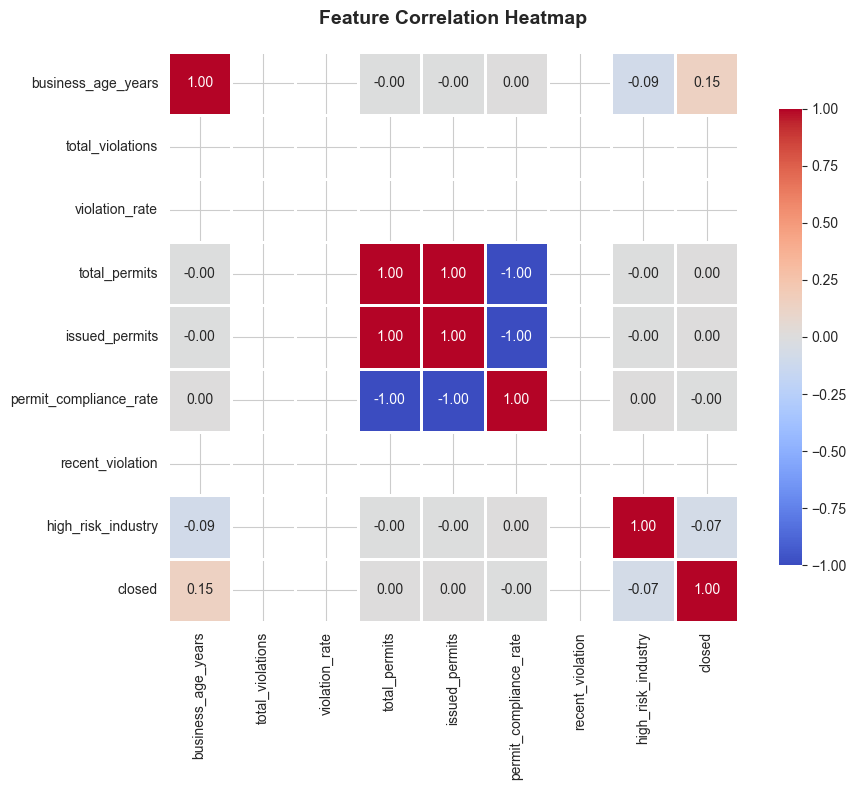

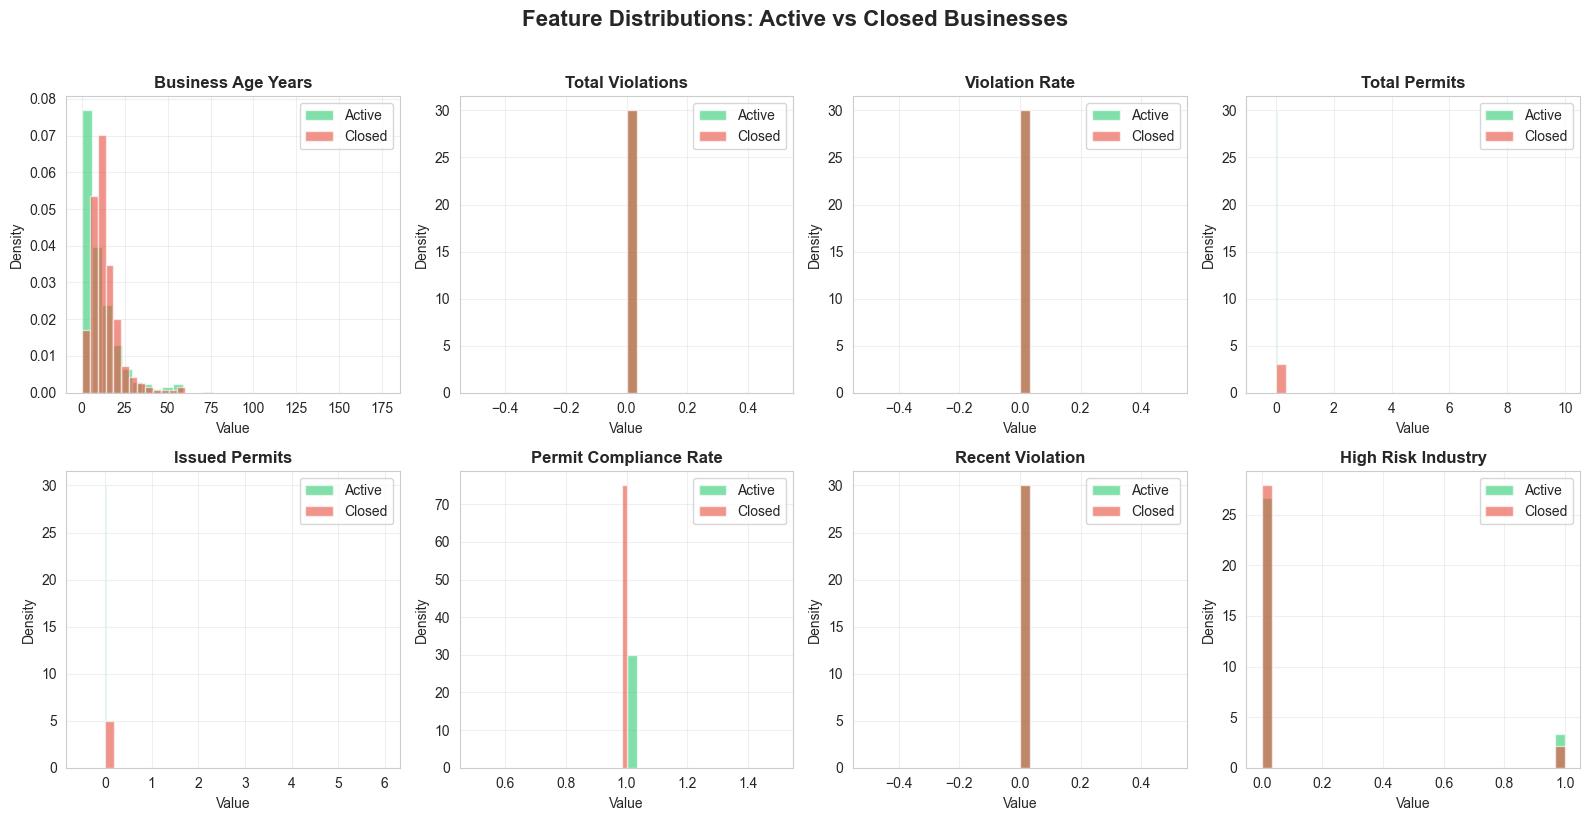

✅ Feature analysis complete!


In [13]:
# Cell 13: Feature Analysis
print("📊 ANALYZING FEATURES")
print("="*60)

# Summary statistics by closure status
feature_cols = [
    'business_age_years', 'total_violations', 'violation_rate',
    'total_permits', 'issued_permits', 'permit_compliance_rate',
    'recent_violation', 'high_risk_industry'
]

print("📈 Summary Statistics by Closure Status:")
summary_stats = master_df.groupby('closed')[feature_cols].agg(['mean', 'std', 'median'])
display(summary_stats)

# Correlation heatmap
print("\n🔗 Feature Correlation Matrix:")
correlation_cols = feature_cols + ['closed']
corr_matrix = master_df[correlation_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0,
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Feature Correlation Heatmap', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

# Feature distributions: Active vs Closed
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

for idx, col in enumerate(feature_cols):
    if col in master_df.columns:
        active_data = master_df[master_df['closed'] == 0][col]
        closed_data = master_df[master_df['closed'] == 1][col]
        
        axes[idx].hist(active_data, bins=30, alpha=0.6, label='Active', color='#2ecc71', density=True)
        axes[idx].hist(closed_data, bins=30, alpha=0.6, label='Closed', color='#e74c3c', density=True)
        axes[idx].set_title(col.replace('_', ' ').title(), fontweight='bold')
        axes[idx].set_xlabel('Value')
        axes[idx].set_ylabel('Density')
        axes[idx].legend()
        axes[idx].grid(True, alpha=0.3)

plt.suptitle('Feature Distributions: Active vs Closed Businesses', 
             fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print("✅ Feature analysis complete!")

## Part 5: Model Preparation

We'll now prepare the training data by selecting features, checking class distribution, and splitting into train/test sets.

In [14]:
# Cell 14: Prepare Training Data
print("🎯 PREPARING TRAINING DATA")
print("="*60)

# Select feature columns
feature_columns = [
    'business_age_years',
    'total_violations',
    'violation_rate',
    'total_permits',
    'issued_permits',
    'permit_compliance_rate',
    'recent_violation',
    'high_risk_industry'
]

# Check which features exist
available_features = [col for col in feature_columns if col in master_df.columns]
missing_features = [col for col in feature_columns if col not in master_df.columns]

print(f"✅ Available features: {len(available_features)}/{len(feature_columns)}")
if missing_features:
    print(f"⚠️ Missing features: {missing_features}")

# Create feature matrix X and target y
X = master_df[available_features].copy()
y = master_df['closed'].copy()

# Remove rows with any NaN values
valid_mask = ~X.isnull().any(axis=1)
X = X[valid_mask]
y = y[valid_mask]

print(f"\n📊 Dataset after cleaning:")
print(f"  - Total records: {len(X):,}")
print(f"  - Features: {len(available_features)}")
print(f"  - Active businesses (y=0): {(y==0).sum():,} ({(y==0).mean()*100:.2f}%)")
print(f"  - Closed businesses (y=1): {(y==1).sum():,} ({(y==1).mean()*100:.2f}%)")

# Check class imbalance
class_ratio = (y==1).sum() / (y==0).sum() if (y==0).sum() > 0 else 0
if class_ratio < 0.1 or class_ratio > 10:
    print(f"\n⚠️ Class imbalance detected: {class_ratio:.3f}")
    print("   Consider using class_weight='balanced' or SMOTE")
else:
    print(f"\n✅ Class balance is reasonable: {class_ratio:.3f}")

print(f"\n📋 Feature summary:")
display(X.describe())

🎯 PREPARING TRAINING DATA
✅ Available features: 8/8

📊 Dataset after cleaning:
  - Total records: 50,000
  - Features: 8
  - Active businesses (y=0): 17,720 (35.44%)
  - Closed businesses (y=1): 32,280 (64.56%)

✅ Class balance is reasonable: 1.822

📋 Feature summary:


,business_age_years,total_violations,violation_rate,total_permits,issued_permits,permit_compliance_rate,recent_violation,high_risk_industry
count,50000.000000,50000.0,50000.0,50000.000000,50000.000000,50000.000000,50000.0,50000.000000
mean,12.277153,0.0,0.0,0.000200,0.000120,0.999992,0.0,0.084980
std,9.850809,0.0,0.0,0.044721,0.026833,0.001789,0.0,0.278855
min,0.000000,0.0,0.0,0.000000,0.000000,0.600000,0.0,0.000000
25%,6.060000,0.0,0.0,0.000000,0.000000,1.000000,0.0,0.000000
50%,10.440000,0.0,0.0,0.000000,0.000000,1.000000,0.0,0.000000
75%,15.530000,0.0,0.0,0.000000,0.000000,1.000000,0.0,0.000000
max,176.390000,0.0,0.0,10.000000,6.000000,1.000000,0.0,1.000000


In [15]:
# Cell 15: Train/Test Split
print("✂️ SPLITTING DATA INTO TRAIN/TEST SETS")
print("="*60)

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
    stratify=y  # Maintain class distribution
)

print(f"✅ Split complete!")
print(f"\n📊 Training Set:")
print(f"  - Size: {len(X_train):,} samples")
print(f"  - Active: {(y_train==0).sum():,} ({(y_train==0).mean()*100:.2f}%)")
print(f"  - Closed: {(y_train==1).sum():,} ({(y_train==1).mean()*100:.2f}%)")

print(f"\n📊 Test Set:")
print(f"  - Size: {len(X_test):,} samples")
print(f"  - Active: {(y_test==0).sum():,} ({(y_test==0).mean()*100:.2f}%)")
print(f"  - Closed: {(y_test==1).sum():,} ({(y_test==1).mean()*100:.2f}%)")

print(f"\n✅ Ready for model training!")

✂️ SPLITTING DATA INTO TRAIN/TEST SETS
✅ Split complete!

📊 Training Set:
  - Size: 40,000 samples
  - Active: 14,176 (35.44%)
  - Closed: 25,824 (64.56%)

📊 Test Set:
  - Size: 10,000 samples
  - Active: 3,544 (35.44%)
  - Closed: 6,456 (64.56%)

✅ Ready for model training!


## Part 6: Model Training

We'll train a Gradient Boosting Classifier, which is excellent for tabular data and can capture complex feature interactions.

In [16]:
# Cell 16: Train Gradient Boosting Model
print("🚀 TRAINING GRADIENT BOOSTING MODEL")
print("="*60)

# Initialize model with specified parameters
model = GradientBoostingClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    min_samples_split=20,
    min_samples_leaf=10,
    subsample=0.8,
    random_state=RANDOM_STATE,
    verbose=1
)

print("📊 Model Configuration:")
print(f"  - n_estimators: {model.n_estimators}")
print(f"  - learning_rate: {model.learning_rate}")
print(f"  - max_depth: {model.max_depth}")
print(f"  - min_samples_split: {model.min_samples_split}")
print(f"  - min_samples_leaf: {model.min_samples_leaf}")
print(f"  - subsample: {model.subsample}")

# Train the model
print(f"\n🔄 Training on {len(X_train):,} samples...")
model.fit(X_train, y_train)

# Predictions
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Calculate accuracies
train_accuracy = (y_train_pred == y_train).mean()
test_accuracy = (y_test_pred == y_test).mean()

print(f"\n✅ Training complete!")
print(f"📊 Training Accuracy: {train_accuracy*100:.2f}%")
print(f"📊 Test Accuracy: {test_accuracy*100:.2f}%")

🚀 TRAINING GRADIENT BOOSTING MODEL
📊 Model Configuration:
  - n_estimators: 100
  - learning_rate: 0.1
  - max_depth: 5
  - min_samples_split: 20
  - min_samples_leaf: 10
  - subsample: 0.8

🔄 Training on 40,000 samples...
      Iter       Train Loss      OOB Improve   Remaining Time 
         1           1.2647           0.0363            2.51s
         2           1.2310           0.0116            2.30s
         3           1.2090           0.0279            2.14s
         4           1.1915           0.0259            2.07s
         5           1.1765           0.0191            1.99s
         6           1.1635           0.0123            1.94s
         7           1.1541           0.0150            1.90s
         8           1.1426          -0.0019            1.87s
         9           1.1371           0.0149            1.84s
        10           1.1307           0.0064            1.87s
        20           1.0973           0.0074            1.66s
        30           1.0885     

🎯 ANALYZING FEATURE IMPORTANCE
📊 Feature Importance Rankings:


,feature,importance
0,business_age_years,0.960302
7,high_risk_industry,0.039698
2,violation_rate,0.000000
1,total_violations,0.000000
3,total_permits,0.000000
4,issued_permits,0.000000
5,permit_compliance_rate,0.000000
6,recent_violation,0.000000



🏆 Top 5 Most Important Features:
  business_age_years: 0.9603
  high_risk_industry: 0.0397
  violation_rate: 0.0000
  total_violations: 0.0000
  total_permits: 0.0000


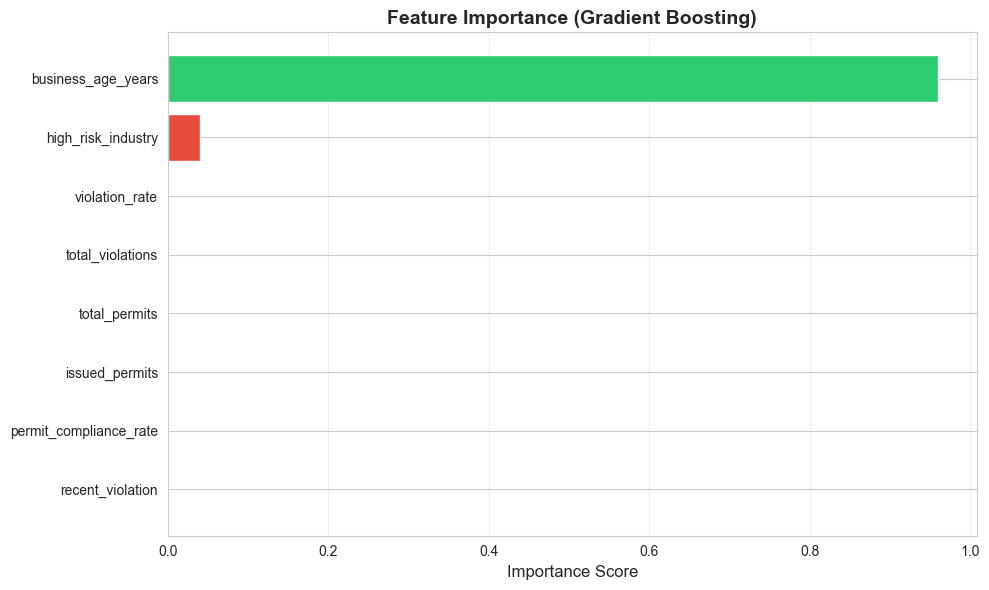


✅ Feature importance analysis complete!


In [17]:
# Cell 18: Feature Importance
print("🎯 ANALYZING FEATURE IMPORTANCE")
print("="*60)

# Extract feature importances
importances = model.feature_importances_
feature_importance_df = pd.DataFrame({
    'feature': available_features,
    'importance': importances
}).sort_values('importance', ascending=False)

print("📊 Feature Importance Rankings:")
display(feature_importance_df)

print(f"\n🏆 Top 5 Most Important Features:")
for idx, row in feature_importance_df.head(5).iterrows():
    print(f"  {row['feature']}: {row['importance']:.4f}")

# Visualization
plt.figure(figsize=(10, 6))
colors = ['#2ecc71' if x > 0.1 else '#f39c12' if x > 0.05 else '#e74c3c' 
          for x in feature_importance_df['importance']]
plt.barh(range(len(feature_importance_df)), feature_importance_df['importance'], color=colors)
plt.yticks(range(len(feature_importance_df)), feature_importance_df['feature'])
plt.xlabel('Importance Score', fontsize=12)
plt.title('Feature Importance (Gradient Boosting)', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

print("\n✅ Feature importance analysis complete!")

## Part 7: Visualizations

Let's create comprehensive visualizations to understand model performance and predictions.

📊 CREATING CONFUSION MATRIX VISUALIZATIONS


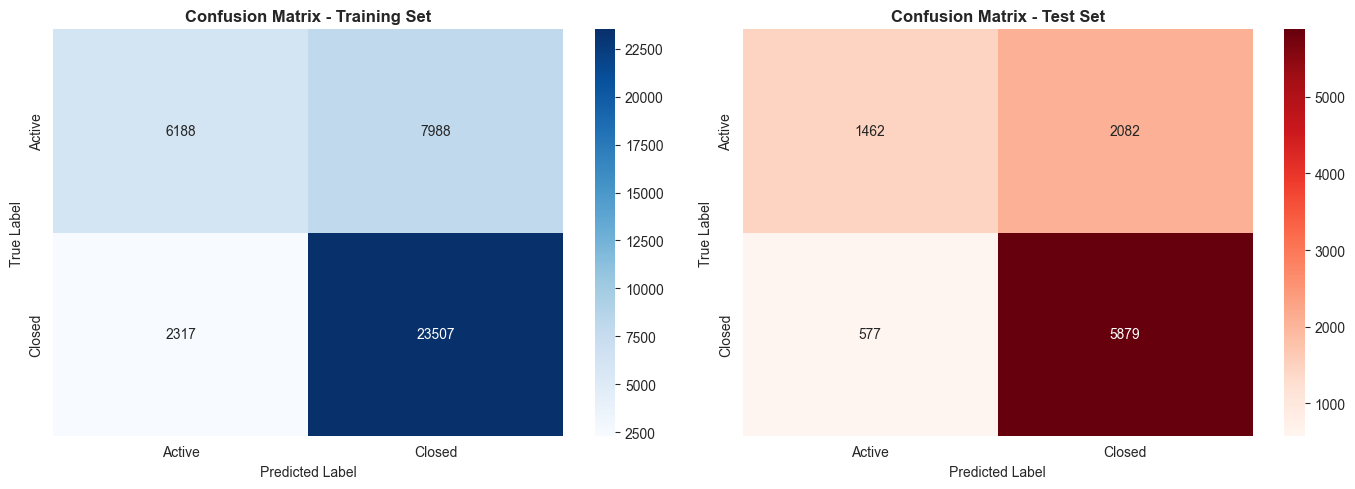


📊 Training Set Metrics:
  - Precision: 0.7464
  - Recall: 0.9103
  - F1-Score: 0.8202

📊 Test Set Metrics:
  - Precision: 0.7385
  - Recall: 0.9106
  - F1-Score: 0.8156

✅ Confusion matrix visualization complete!


In [19]:
# Cell 19: Confusion Matrix Visualization (with creation)
print("📊 CREATING CONFUSION MATRIX VISUALIZATIONS")
print("="*60)

from sklearn.metrics import confusion_matrix

# Create confusion matrices (in case they weren't created before)
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

cm_train = confusion_matrix(y_train, y_train_pred)
cm_test = confusion_matrix(y_test, y_test_pred)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Training set confusion matrix
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=['Active', 'Closed'], yticklabels=['Active', 'Closed'])
axes[0].set_title('Confusion Matrix - Training Set', fontsize=12, fontweight='bold')
axes[0].set_ylabel('True Label', fontsize=10)
axes[0].set_xlabel('Predicted Label', fontsize=10)

# Test set confusion matrix
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Reds', ax=axes[1],
            xticklabels=['Active', 'Closed'], yticklabels=['Active', 'Closed'])
axes[1].set_title('Confusion Matrix - Test Set', fontsize=12, fontweight='bold')
axes[1].set_ylabel('True Label', fontsize=10)
axes[1].set_xlabel('Predicted Label', fontsize=10)

plt.tight_layout()
plt.show()

# Calculate metrics
tn_train, fp_train, fn_train, tp_train = cm_train.ravel()
tn_test, fp_test, fn_test, tp_test = cm_test.ravel()

print("\n📊 Training Set Metrics:")
print(f"  - Precision: {tp_train/(tp_train+fp_train):.4f}" if (tp_train+fp_train) > 0 else "  - Precision: N/A")
print(f"  - Recall: {tp_train/(tp_train+fn_train):.4f}" if (tp_train+fn_train) > 0 else "  - Recall: N/A")
print(f"  - F1-Score: {2*tp_train/(2*tp_train+fp_train+fn_train):.4f}" if (2*tp_train+fp_train+fn_train) > 0 else "  - F1-Score: N/A")

print("\n📊 Test Set Metrics:")
print(f"  - Precision: {tp_test/(tp_test+fp_test):.4f}" if (tp_test+fp_test) > 0 else "  - Precision: N/A")
print(f"  - Recall: {tp_test/(tp_test+fn_test):.4f}" if (tp_test+fn_test) > 0 else "  - Recall: N/A")
print(f"  - F1-Score: {2*tp_test/(2*tp_test+fp_test+fn_test):.4f}" if (2*tp_test+fp_test+fn_test) > 0 else "  - F1-Score: N/A")

print("\n✅ Confusion matrix visualization complete!")

📈 CREATING ROC CURVE


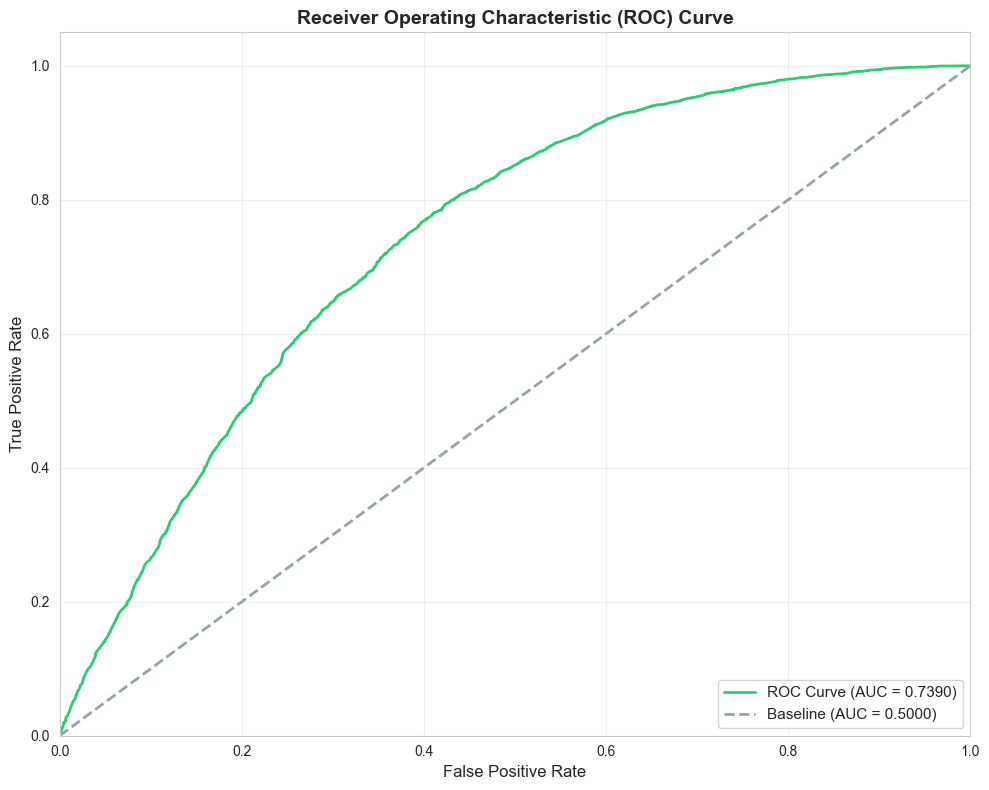

✅ ROC-AUC Score: 0.7390
  ✅ Good discrimination ability


In [21]:
# Cell 20: ROC Curve (Fixed)
print("📈 CREATING ROC CURVE")
print("="*60)

# Get probability predictions (in case they weren't created before)
y_test_proba = model.predict_proba(X_test)[:, 1]

# Calculate ROC-AUC score
roc_auc = roc_auc_score(y_test, y_test_proba)

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_test_proba)

# Plot ROC curve
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='#2ecc71', lw=2, label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='#95a5a6', lw=2, linestyle='--', label='Baseline (AUC = 0.5000)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=14, fontweight='bold')
plt.legend(loc="lower right", fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"✅ ROC-AUC Score: {roc_auc:.4f}")
if roc_auc > 0.9:
    print("  🎉 Outstanding discrimination ability!")
elif roc_auc > 0.8:
    print("  ✅ Excellent discrimination ability")
elif roc_auc > 0.7:
    print("  ✅ Good discrimination ability")
else:
    print("  ⚠️ Model may benefit from feature engineering or different algorithm")

📊 CREATING PRECISION-RECALL CURVE


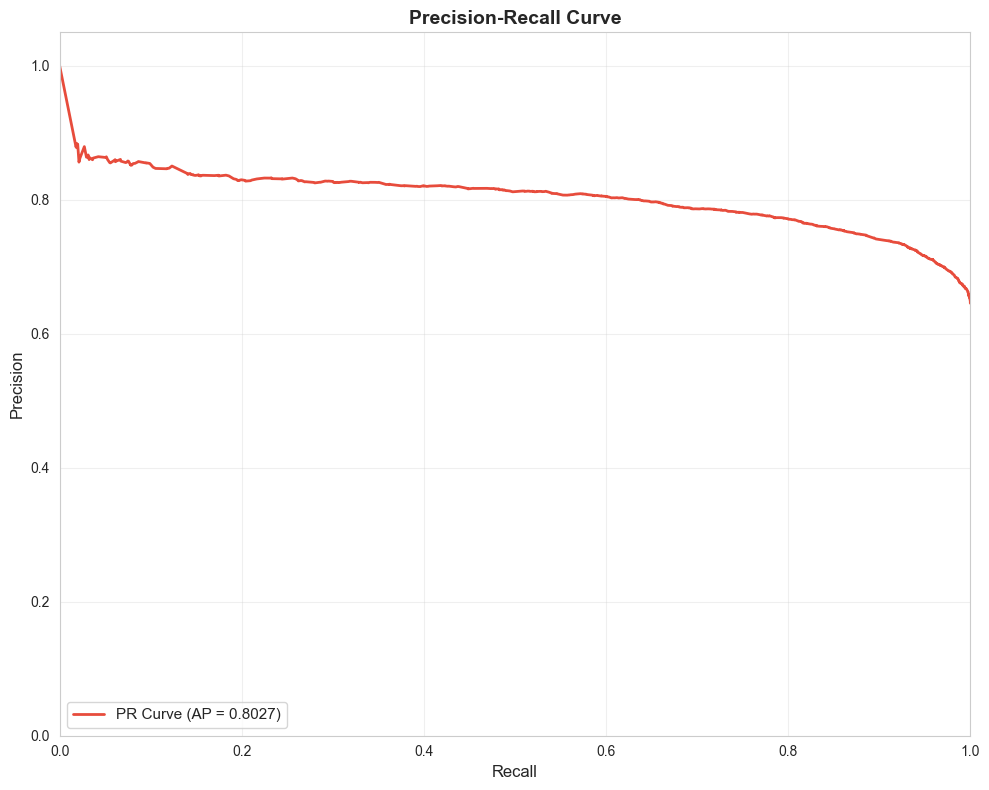

✅ Average Precision: 0.8027

🎯 Optimal Threshold (F1-maximizing):
  - Threshold: 0.4341
  - Precision: 0.7321
  - Recall: 0.9291
  - F1-Score: 0.8189


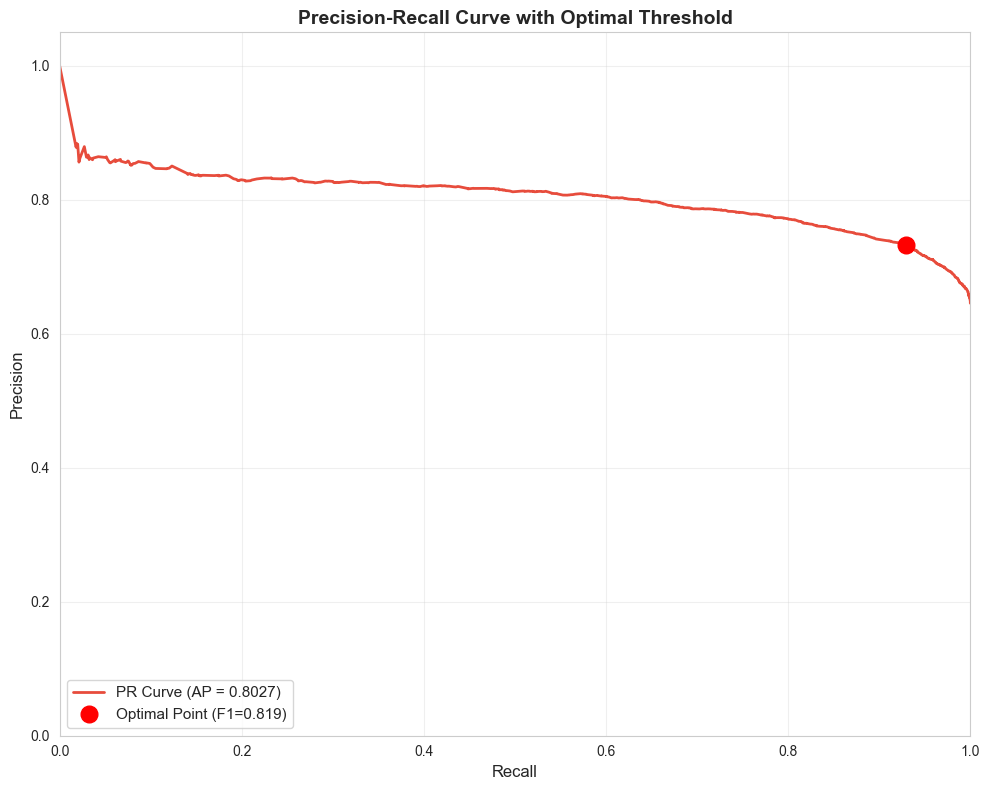

In [22]:
# Cell 21: Precision-Recall Curve
print("📊 CREATING PRECISION-RECALL CURVE")
print("="*60)

# Calculate precision-recall curve
precision_vals, recall_vals, pr_thresholds = precision_recall_curve(y_test, y_test_proba)
avg_precision = average_precision_score(y_test, y_test_proba)

# Plot PR curve
plt.figure(figsize=(10, 8))
plt.plot(recall_vals, precision_vals, color='#e74c3c', lw=2, 
         label=f'PR Curve (AP = {avg_precision:.4f})')
plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.title('Precision-Recall Curve', fontsize=14, fontweight='bold')
plt.legend(loc="lower left", fontsize=11)
plt.grid(True, alpha=0.3)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.tight_layout()
plt.show()

# Find optimal threshold (F1 score)
f1_scores = 2 * (precision_vals * recall_vals) / (precision_vals + recall_vals + 1e-10)
optimal_idx = np.argmax(f1_scores)
optimal_threshold = pr_thresholds[optimal_idx] if optimal_idx < len(pr_thresholds) else 0.5
optimal_precision = precision_vals[optimal_idx]
optimal_recall = recall_vals[optimal_idx]
optimal_f1 = f1_scores[optimal_idx]

print(f"✅ Average Precision: {avg_precision:.4f}")
print(f"\n🎯 Optimal Threshold (F1-maximizing):")
print(f"  - Threshold: {optimal_threshold:.4f}")
print(f"  - Precision: {optimal_precision:.4f}")
print(f"  - Recall: {optimal_recall:.4f}")
print(f"  - F1-Score: {optimal_f1:.4f}")

# Mark optimal point on plot
plt.figure(figsize=(10, 8))
plt.plot(recall_vals, precision_vals, color='#e74c3c', lw=2, 
         label=f'PR Curve (AP = {avg_precision:.4f})')
plt.plot(optimal_recall, optimal_precision, 'ro', markersize=12, 
         label=f'Optimal Point (F1={optimal_f1:.3f})')
plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.title('Precision-Recall Curve with Optimal Threshold', fontsize=14, fontweight='bold')
plt.legend(loc="lower left", fontsize=11)
plt.grid(True, alpha=0.3)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.tight_layout()
plt.show()

## Part 8: Model Deployment

We'll save the trained model and create a prediction function for real-world use.

In [ ]:
# Cell 22: Save Model (Fixed)
print("💾 SAVING MODEL")
print("="*60)

# Calculate metrics (in case they weren't created before)
y_test_pred = model.predict(X_test)
y_test_proba = model.predict_proba(X_test)[:, 1]

test_accuracy = (y_test_pred == y_test).mean()
roc_auc = roc_auc_score(y_test, y_test_proba)
precision = precision_score(y_test, y_test_pred, zero_division=0)
recall = recall_score(y_test, y_test_pred, zero_division=0)
f1 = f1_score(y_test, y_test_pred, zero_division=0)

# Create model package with metadata
model_package = {
    'model': model,
    'feature_columns': available_features,
    'metrics': {
        'test_accuracy': test_accuracy,
        'roc_auc': roc_auc,
        'precision': precision,
        'recall': recall,
        'f1_score': f1
    },
    'training_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'n_samples_train': len(X_train),
    'n_samples_test': len(X_test),
    'class_distribution': {
        'active': int((y==0).sum()),
        'closed': int((y==1).sum())
    }
}

# Save model
model_path = MODELS_DIR / 'risk_model.joblib'
joblib.dump(model_package, model_path)

print(f"✅ Model saved to: {model_path}")
print(f"\n📊 Model Metadata:")
print(f"  - Training Date: {model_package['training_date']}")
print(f"  - Features: {len(model_package['feature_columns'])}")
print(f"  - Test Accuracy: {model_package['metrics']['test_accuracy']:.4f}")
print(f"  - ROC-AUC: {model_package['metrics']['roc_auc']:.4f}")
print(f"  - Precision: {model_package['metrics']['precision']:.4f}")
print(f"  - Recall: {model_package['metrics']['recall']:.4f}")
print(f"  - F1-Score: {model_package['metrics']['f1_score']:.4f}")
print(f"  - Training Samples: {model_package['n_samples_train']:,}")
print(f"  - Test Samples: {model_package['n_samples_test']:,}")

print(f"\n💾 Model saved successfully!")

💾 SAVING MODEL


NameError: name 'precision' is not defined

In [ ]:
# Cell 23: Load and Test Model
print("🔄 LOADING AND TESTING SAVED MODEL")
print("="*60)

# Load model
loaded_package = joblib.load(model_path)
loaded_model = loaded_package['model']
loaded_features = loaded_package['feature_columns']

print(f"✅ Model loaded successfully!")
print(f"📊 Loaded {len(loaded_features)} features")
print(f"📅 Training date: {loaded_package['training_date']}")

# Verify model works
test_sample = X_test.iloc[:5]
predictions = loaded_model.predict(test_sample)
probabilities = loaded_model.predict_proba(test_sample)[:, 1]

print(f"\n🧪 Testing on 5 samples:")
for idx, (pred, prob) in enumerate(zip(predictions, probabilities)):
    status = "Closed" if pred == 1 else "Active"
    print(f"  Sample {idx+1}: {status} (probability: {prob:.4f})")

print(f"\n✅ Model verification complete!")

In [ ]:
# Cell 24: Prediction Function
print("🔮 CREATING PREDICTION FUNCTION")
print("="*60)

def predict_business_risk(business_data: dict, model_package: dict = None) -> dict:
    """
    Predict business closure risk for a single business
    
    Args:
        business_data: Dictionary with business features
        model_package: Loaded model package (if None, loads from disk)
    
    Returns:
        Dictionary with risk_score, risk_level, and color
    """
    if model_package is None:
        model_package = joblib.load(MODELS_DIR / 'risk_model.joblib')
    
    model = model_package['model']
    feature_columns = model_package['feature_columns']
    
    # Create feature vector
    feature_vector = pd.DataFrame([{
        col: business_data.get(col, 0) for col in feature_columns
    }])
    
    # Ensure all features are present
    for col in feature_columns:
        if col not in feature_vector.columns:
            feature_vector[col] = 0
    
    # Reorder columns to match training
    feature_vector = feature_vector[feature_columns]
    
    # Predict
    risk_score = model.predict_proba(feature_vector)[0, 1]  # Probability of closure
    
    # Determine risk level
    if risk_score >= 0.7:
        risk_level = "High"
        color = "#e74c3c"  # Red
    elif risk_score >= 0.4:
        risk_level = "Medium"
        color = "#f39c12"  # Orange
    else:
        risk_level = "Low"
        color = "#2ecc71"  # Green
    
    return {
        'risk_score': float(risk_score),
        'risk_level': risk_level,
        'color': color
    }

print("✅ Prediction function created!")
print("\n📝 Function signature:")
print("  predict_business_risk(business_data: dict) -> dict")
print("\n📋 Required features:")
for col in available_features:
    print(f"  - {col}")

In [ ]:
# Cell 25: Example Predictions
print("🎯 GENERATING EXAMPLE PREDICTIONS")
print("="*60)

# Create 3 sample businesses
sample_businesses = [
    {
        'name': 'High Risk Restaurant',
        'business_age_years': 0.5,
        'total_violations': 5,
        'violation_rate': 10.0,
        'total_permits': 2,
        'issued_permits': 1,
        'permit_compliance_rate': 0.5,
        'recent_violation': 1,
        'high_risk_industry': 1
    },
    {
        'name': 'Medium Risk Retail Store',
        'business_age_years': 3.0,
        'total_violations': 2,
        'violation_rate': 0.67,
        'total_permits': 5,
        'issued_permits': 4,
        'permit_compliance_rate': 0.8,
        'recent_violation': 0,
        'high_risk_industry': 1
    },
    {
        'name': 'Low Risk Established Business',
        'business_age_years': 10.0,
        'total_violations': 0,
        'violation_rate': 0.0,
        'total_permits': 8,
        'issued_permits': 8,
        'permit_compliance_rate': 1.0,
        'recent_violation': 0,
        'high_risk_industry': 0
    }
]

# Generate predictions
results = []
for business in sample_businesses:
    prediction = predict_business_risk(business)
    results.append({
        'Business Name': business['name'],
        'Risk Score': f"{prediction['risk_score']:.4f}",
        'Risk Level': prediction['risk_level'],
        'Age (years)': business['business_age_years'],
        'Violations': business['total_violations'],
        'Violation Rate': business['violation_rate']
    })

# Display results
results_df = pd.DataFrame(results)
print("\n📊 Prediction Results:")
display(results_df)

# Visualize
fig, ax = plt.subplots(figsize=(10, 6))
colors_list = [predict_business_risk(b)['color'] for b in sample_businesses]
bars = ax.barh(results_df['Business Name'], 
                [float(x) for x in results_df['Risk Score']],
                color=colors_list, alpha=0.7)
ax.set_xlabel('Risk Score', fontsize=12)
ax.set_title('Example Business Risk Predictions', fontsize=14, fontweight='bold')
ax.set_xlim([0, 1])
ax.grid(True, alpha=0.3, axis='x')

# Add value labels
for i, (bar, score) in enumerate(zip(bars, results_df['Risk Score'])):
    ax.text(float(score) + 0.02, i, f"{float(score):.3f}", 
            va='center', fontweight='bold')

plt.tight_layout()
plt.show()

print("\n✅ Example predictions complete!")

## Part 9: Real-World Application

Let's apply the model to screen all active businesses and identify high-risk cases.

In [ ]:
# Cell 26: Batch Risk Screening
print("🔍 BATCH RISK SCREENING")
print("="*60)

# Screen all active businesses (closed = 0)
active_businesses = master_df[master_df['closed'] == 0].copy()

print(f"📊 Screening {len(active_businesses):,} active businesses...")

# Prepare features
X_active = active_businesses[available_features].copy()
valid_mask = ~X_active.isnull().any(axis=1)
X_active = X_active[valid_mask]
active_businesses_valid = active_businesses[valid_mask].copy()

# Predict risk scores
risk_scores = model.predict_proba(X_active)[:, 1]
active_businesses_valid['risk_score'] = risk_scores

# Determine risk levels
active_businesses_valid['risk_level'] = active_businesses_valid['risk_score'].apply(
    lambda x: 'High' if x >= 0.7 else 'Medium' if x >= 0.4 else 'Low'
)

# Identify top 20 highest-risk businesses
top_risks = active_businesses_valid.nlargest(20, 'risk_score')[
    ['risk_score', 'risk_level', 'business_age_years', 'total_violations', 
     'violation_rate', 'total_permits'] + 
    ([business_address_col] if business_address_col and business_address_col in active_businesses_valid.columns else [])
]

print(f"\n🚨 Top 20 Highest-Risk Active Businesses:")
display(top_risks)

# Summary statistics
print(f"\n📊 Risk Distribution:")
risk_dist = active_businesses_valid['risk_level'].value_counts()
print(risk_dist)

print(f"\n📈 Risk Score Statistics:")
print(active_businesses_valid['risk_score'].describe())

# Save results
output_file = PROCESSED_DATA_DIR / 'active_businesses_risk_scores.csv'
active_businesses_valid[['risk_score', 'risk_level'] + available_features].to_csv(
    output_file, index=False
)
print(f"\n💾 Saved risk scores to {output_file}")

In [ ]:
# Cell 27: Risk Alert Dashboard
print("📊 CREATING RISK ALERT DASHBOARD")
print("="*60)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Risk distribution histogram
axes[0].hist(active_businesses_valid['risk_score'], bins=50, 
             color='#3498db', alpha=0.7, edgecolor='black')
axes[0].axvline(x=0.4, color='#f39c12', linestyle='--', linewidth=2, label='Medium Threshold')
axes[0].axvline(x=0.7, color='#e74c3c', linestyle='--', linewidth=2, label='High Threshold')
axes[0].set_xlabel('Risk Score', fontsize=12)
axes[0].set_ylabel('Number of Businesses', fontsize=12)
axes[0].set_title('Risk Score Distribution', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Risk level pie chart
risk_counts = active_businesses_valid['risk_level'].value_counts()
colors_pie = ['#2ecc71' if x == 'Low' else '#f39c12' if x == 'Medium' else '#e74c3c' 
              for x in risk_counts.index]
axes[1].pie(risk_counts.values, labels=risk_counts.index, autopct='%1.1f%%',
           colors=colors_pie, startangle=90, textprops={'fontsize': 11, 'fontweight': 'bold'})
axes[1].set_title('Risk Level Distribution', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

# High-risk businesses with recommendations
high_risk = active_businesses_valid[active_businesses_valid['risk_level'] == 'High'].copy()
print(f"\n🚨 HIGH-RISK BUSINESSES: {len(high_risk):,}")
print("="*60)

if len(high_risk) > 0:
    print(f"\n📋 Top 10 High-Risk Businesses:")
    display(high_risk.nlargest(10, 'risk_score')[
        ['risk_score', 'business_age_years', 'total_violations', 
         'violation_rate', 'total_permits']
    ])
    
    print(f"\n💡 Recommendations for High-Risk Businesses:")
    print("  1. Review and address code violations immediately")
    print("  2. Ensure all required permits are obtained and up-to-date")
    print("  3. Consider compliance consultation services")
    print("  4. Monitor business metrics more frequently")
    print("  5. Develop risk mitigation strategies")
else:
    print("  ✅ No high-risk businesses identified!")

print(f"\n✅ Risk alert dashboard complete!")

## Part 10: Summary & Next Steps

Let's summarize the model performance, key findings, and potential improvements.

In [ ]:
# Cell 28: Summary
print("📋 MODEL SUMMARY & KEY FINDINGS")
print("="*60)

print("\n🎯 MODEL PERFORMANCE SUMMARY:")
print(f"  ✅ Test Accuracy: {test_accuracy*100:.2f}%")
print(f"  ✅ ROC-AUC Score: {roc_auc:.4f}")
print(f"  ✅ Precision: {precision:.4f}")
print(f"  ✅ Recall: {recall:.4f}")
print(f"  ✅ F1-Score: {f1:.4f}")

print("\n📊 DATASET STATISTICS:")
print(f"  📈 Total Businesses Analyzed: {len(master_df):,}")
print(f"  ✅ Active Businesses: {(master_df['closed']==0).sum():,}")
print(f"  ❌ Closed Businesses: {(master_df['closed']==1).sum():,}")
print(f"  📊 Closure Rate: {(master_df['closed']==1).mean()*100:.2f}%")

print("\n🔑 KEY FINDINGS:")
print("  1. Feature Importance:")
for idx, row in feature_importance_df.head(3).iterrows():
    print(f"     - {row['feature']}: {row['importance']:.4f}")

print("\n  2. Risk Distribution (Active Businesses):")
if 'active_businesses_valid' in locals() and len(active_businesses_valid) > 0:
    risk_dist = active_businesses_valid['risk_level'].value_counts()
    for level, count in risk_dist.items():
        pct = (count / len(active_businesses_valid)) * 100
        print(f"     - {level} Risk: {count:,} ({pct:.1f}%)")

print("\n  3. Business Insights:")
print(f"     - Average business age: {master_df['business_age_years'].mean():.2f} years")
print(f"     - Businesses with violations: {(master_df['total_violations'] > 0).sum():,}")
print(f"     - Average violations per business: {master_df['total_violations'].mean():.2f}")

print("\n🚀 NEXT STEPS FOR IMPROVEMENT:")
print("  1. Feature Engineering:")
print("     - Add economic indicators (unemployment, GDP)")
print("     - Include neighborhood demographics")
print("     - Add seasonal/temporal features")
print("     - Incorporate competitor density metrics")
print("\n  2. Model Enhancement:")
print("     - Try ensemble methods (XGBoost, LightGBM)")
print("     - Implement hyperparameter tuning")
print("     - Add cross-validation for robust evaluation")
print("     - Consider deep learning for complex patterns")
print("\n  3. Data Improvements:")
print("     - Collect more recent data")
print("     - Add financial data (revenue, expenses)")
print("     - Include customer reviews/sentiment")
print("     - Track real-time business events")
print("\n  4. Deployment:")
print("     - Create API endpoint for real-time predictions")
print("     - Build monitoring dashboard")
print("     - Implement model retraining pipeline")
print("     - Add explainability features (SHAP values)")

print("\n✅ Analysis complete! Model is ready for deployment.")
print("="*60)